<a href="https://colab.research.google.com/github/cogitare-aude/datasharing/blob/master/preply_subx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install Packages & Libraries

In [ ]:
#give access to My Drive (Google Drive)
from google.colab import drive
drive.mount('/content/drive')

#define path for this project
import os
os.chdir('drive/My Drive/Colab Notebooks/Interview/Preply')

Mounted at /content/drive


In [ ]:
#load relevant libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

#for reading Excel files
#%pip install xlrd

#libraries for reading Google sheets
!pip install gspread google-auth
import gspread
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.auth import default

#for SQL
!pip install pandasql
from pandasql import sqldf

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26772 sha256=aed3bbdd3aefa824ccc6eb4548f6c3f11e07a6660eecbc4759ae9314d759a25f
  Stored in directory: /root/.cache/pip/wheels/e9/bc/3a/8434bdcccf5779e72894a9b24fecbdcaf97940607eaf4bcdf9
Successfully built pandasql


In [ ]:
#for AB-testing
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

#for visuals
from scipy import stats

#Reading Data

##Fetching

In [ ]:
#reading data

#auth & create a client
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

#open Google Sheet by URL
spreadsheet_url = 'https://docs.google.com/spreadsheets/d/14qqBUyZpbh0T2OtI-QttoCAm_vjghbpn4rCFScSpn_c/edit?gid=0#gid=0'
sh = gc.open_by_url(spreadsheet_url)
worksheet = sh.worksheet('participants')
data = worksheet.get_all_values()

df_participant = pd.DataFrame(data[1:], columns=data[0])


spreadsheet_url_i = 'https://docs.google.com/spreadsheets/d/14qqBUyZpbh0T2OtI-QttoCAm_vjghbpn4rCFScSpn_c/edit?gid=853844270#gid=853844270'
sh_i = gc.open_by_url(spreadsheet_url_i)
worksheet_i = sh_i.worksheet('transactions')
data_i = worksheet_i.get_all_values()

df_trans = pd.DataFrame(data_i[1:], columns=data_i[0])

In [ ]:
df_trans.count()

,0
user_id,3804
gmv,3804
payment_time,3804
payment_type,3804


##Checking Data Sample

In [ ]:
df_cvr = sqldf('''

  SELECT
    user_id,
    payment_time,
    payment_type,
    gmv
  FROM df_trans
  WHERE user_id = '10051681'

  ''', env=None)

df_cvr

,user_id,payment_time,payment_type,gmv
0,10051681,2023-07-18 13:30:01,12-week,341.14
1,10051681,2023-06-20 13:30:01,monthly,52.00


In [ ]:
df_base = sqldf('''

  SELECT
    *,
    DATE(test_entrance_time, '+8 days') AS exp_dt
  FROM df_participant
  WHERE user_id = '10051681'

  ''', env=None)

df_base

,user_id,test_group,test_entrance_time,exp_dt
0,10051681,B,2023-07-15 14:50:54,2023-07-23


##Preparing Data (SQL)

In [ ]:
df_base = sqldf('''

  WITH conversion AS (
    SELECT
      base.user_id,
      base.test_group,
      base.test_entrance_time,

      trans.user_id AS joined_user,
      trans.payment_time,

      --totla values at unique user level
      CASE WHEN trans.user_id IS NOT NULL THEN 1 ELSE 0 END AS conversion_flg,
      CASE WHEN trans.user_id IS NOT NULL AND trans.payment_type = '12-week' THEN 1 ELSE 0 END AS three_mo_cvr_flg,

      SUM(CASE WHEN trans.user_id IS NOT NULL AND trans.payment_type = '12-week' THEN trans.gmv ELSE 0 END) AS mmm_gmv,
      SUM(CASE WHEN trans.user_id IS NOT NULL AND trans.payment_type = 'monthly' THEN trans.gmv ELSE 0 END) AS mo_gmv

    FROM df_participant AS base

    LEFT JOIN df_trans AS trans
    ON base.user_id = trans.user_id
      AND DATE(trans.payment_time) BETWEEN DATE(base.test_entrance_time) AND DATE(base.test_entrance_time, '+8 days')
        --checking the 7-day asusmption (no one in experiment paid a second monthly sub)
        --AND DATE(trans.payment_time) > DATE(base.test_entrance_time, '+8 days')
      AND trans.payment_type IN ('monthly', '12-week') --exclude "top-up" which assumes as retention behaviour

    --test case
    --WHERE base.user_id = '1137398'
    GROUP BY 1,2,3,4,5,6,7

  ),
    --test: check dup
    --SELECT user_id, count(*) AS cnt FROM conversion GROUP BY 1 HAVING cnt >1

  retention AS (
    SELECT
      base.user_id,
      test_group,
      test_entrance_time,
      conversion_flg,
      three_mo_cvr_flg,
      mmm_gmv,
      mo_gmv,

      SUM(CASE WHEN trans.user_id IS NOT NULL THEN 1 ELSE 0 END) AS topup_cnt,
      SUM(CASE WHEN trans.user_id IS NOT NULL AND three_mo_cvr_flg= 1 THEN 1 ELSE 0 END) AS mmm_topup_cnt,

      MAX(CASE WHEN trans.user_id IS NOT NULL AND conversion_flg = 1 THEN 1 ELSE 0 END) AS retention_flg,
      MAX(CASE WHEN trans.user_id IS NOT NULL AND three_mo_cvr_flg= 1 THEN 1 ELSE 0 END) AS mmm_rnt_flg,

      --only users that toped-up after joining experiemnt & converted within experiment
      SUM(CASE WHEN trans.user_id IS NOT NULL AND conversion_flg = 1 THEN trans.gmv ELSE 0 END) AS topup_gmv,
      SUM(CASE WHEN trans.user_id IS NOT NULL AND three_mo_cvr_flg = 1 THEN trans.gmv ELSE 0 END) AS mmm_topup_gmv

    FROM conversion AS base

    LEFT JOIN df_trans AS trans
    ON base.user_id = trans.user_id
      AND DATE(trans.payment_time) >= DATE(base.test_entrance_time)
      AND trans.payment_type IN ('top-up') --retention = top-up b/c no one in this 1-month experiment paid a second monthly sub

    --test case
    --WHERE base.user_id = '9922657'

    GROUP BY 1,2,3,4,5,6,7
  )
    --test: check dup
    --SELECT user_id, count(*) AS cnt FROM retention GROUP BY 1 HAVING cnt >1

  SELECT * FROM retention

  ''', env=None)

df_base.head(10)

,user_id,test_group,test_entrance_time,conversion_flg,three_mo_cvr_flg,mmm_gmv,mo_gmv,topup_cnt,mmm_topup_cnt,retention_flg,mmm_rnt_flg,topup_gmv,mmm_topup_gmv
0,10000010,B,2023-07-04 17:47:31,0,0,0.0,0.0,0,0,0,0,0.0,0.0
1,10000641,B,2023-07-12 14:07:16,0,0,0.0,0.0,2,0,0,0,0.0,0.0
2,10001317,B,2023-07-01 21:36:59,1,0,0.0,47.0,1,0,1,0,47.0,0.0
3,10001483,B,2023-07-14 20:21:58,0,0,0.0,0.0,0,0,0,0,0.0,0.0
4,10001839,B,2023-07-12 19:36:21,0,0,0.0,0.0,0,0,0,0,0.0,0.0
5,10002343,A,2023-07-12 11:38:42,0,0,0.0,0.0,0,0,0,0,0.0,0.0
6,10002506,A,2023-07-04 19:42:29,0,0,0.0,0.0,0,0,0,0,0.0,0.0
7,10002965,B,2023-07-05 10:19:33,0,0,0.0,0.0,0,0,0,0,0.0,0.0
8,10003566,A,2023-07-03 17:57:51,0,0,0.0,0.0,0,0,0,0,0.0,0.0
9,10003648,B,2023-07-03 19:33:08,0,0,0.0,0.0,0,0,0,0,0.0,0.0


In [ ]:
df_resub = sqldf('''

  WITH resub AS (
    SELECT
      base.user_id,
      base.test_group,
      base.test_entrance_time,

      trans.user_id AS joined_user,
      trans.payment_time,
      ROUND(JULIANDAY(trans.payment_time) - JULIANDAY(base.test_entrance_time)) AS date_diff,

      --totla values at unique user level
      CASE WHEN trans.user_id IS NOT NULL THEN 1 ELSE 0 END AS conversion_flg,
      CASE WHEN trans.user_id IS NOT NULL AND trans.payment_type = '12-week' THEN 1 ELSE 0 END AS three_mo_cvr_flg,
      CASE WHEN trans.user_id IS NOT NULL AND trans.payment_type = 'monthly' THEN 1 ELSE 0 END AS monthly_cvr_flg

    FROM df_participant AS base

    LEFT JOIN df_trans AS trans
    ON base.user_id = trans.user_id
      AND DATE(trans.payment_time) >= DATE(base.test_entrance_time)
      AND trans.payment_type IN ('monthly', '12-week') --exclude "top-up" which assumes as retention behaviour

    --test case
    --WHERE base.user_id = '1137398'
  )
    --test: check dup
    --SELECT user_id, count(*) AS cnt FROM resub GROUP BY 1 HAVING cnt >1

  SELECT * FROM resub

  ''', env=None)

df_resub.head()

,user_id,test_group,test_entrance_time,joined_user,payment_time,date_diff,conversion_flg,three_mo_cvr_flg,monthly_cvr_flg
0,8683309,A,2023-06-21 13:40:41,None,None,NaN,0,0,0
1,9683309,A,2023-06-21 13:40:42,None,None,NaN,0,0,0
2,10683309,A,2023-06-21 13:40:43,None,None,NaN,0,0,0
3,8573473,A,2023-06-21 13:41:54,8573473,2023-06-23 13:41:51,2.0,1,0,1
4,9573473,A,2023-06-21 13:41:56,9573473,2023-06-23 13:41:51,2.0,1,0,1


In [ ]:
#check purchase behaviour given 7-day promo window
df_resub.groupby('test_group')['date_diff'].max()

,date_diff
test_group,
A,3.0
B,3.0


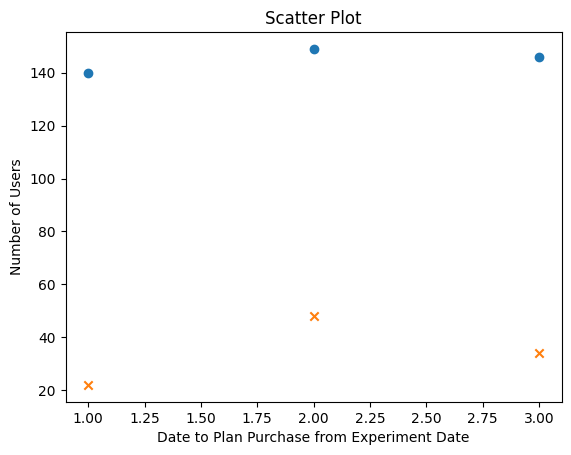

In [ ]:
#plot the payment date diff of Group A that purchased monthly subx
df_resub_m_b = df_resub[(df_resub['test_group'] == 'B') & (df_resub['monthly_cvr_flg'] == 1)]
df_resub_mmm_b = df_resub[(df_resub['test_group'] == 'B') & (df_resub['three_mo_cvr_flg'] == 1)]


df_resub_m_b_cnt = df_resub_m_b.groupby('date_diff')['user_id'].count().reset_index()
df_resub_m_b_cnt.rename(columns={'user_id': 'user_count'}, inplace=True)

df_resub_mmm_cnt = df_resub_mmm_b.groupby('date_diff')['user_id'].count().reset_index()
df_resub_mmm_cnt.rename(columns={'user_id': 'user_count'}, inplace=True)

plt.scatter(df_resub_m_b_cnt['date_diff'], df_resub_m_b_cnt['user_count'], marker='o')
plt.scatter(df_resub_mmm_cnt['date_diff'], df_resub_mmm_cnt['user_count'], marker='x')


plt.xlabel('Date to Plan Purchase from Experiment Date')
plt.ylabel('Number of Users')
plt.title('Scatter Plot')

plt.show()

In [ ]:
#plot the payment date diff of Group A that purchased monthly subx
df_resub_a = df_resub[(df_resub['test_group'] == 'B') & (df_resub['conversion_flg'] == 1)]

df_resub_a_cnt = df_resub_a.groupby('date_diff')['user_id'].count().reset_index()
df_resub_a_cnt.rename(columns={'user_id': 'user_count'}, inplace=True)

plt.scatter(df_resub_a_cnt['date_diff'], df_resub_a_cnt['user_count'])
plt.xlabel('Date to Plan Purchase from Experiment Date')
plt.ylabel('Number of Users')
plt.title('Scatter Plot')

plt.show()

In [ ]:
#plot the payment date diff of Group A that purchased monthly subx
df_resub_a = df_resub[(df_resub['test_group'] == 'B') & (df_resub['conversion_flg'] == 1)]

df_resub_a_cnt = df_resub_a.groupby('date_diff','')['user_id'].count().reset_index()
df_resub_a_cnt.rename(columns={'user_id': 'user_count'}, inplace=True)

df_resub_a_cnt

,date_diff,user_count
0,-59.0,9
1,-58.0,18
2,-57.0,6
3,-27.0,17
4,-26.0,22
5,-25.0,15
6,1.0,162
7,2.0,197
8,3.0,180


#Analyzing AB Test (CVR)

In [ ]:
df_base.head()

,user_id,test_group,test_entrance_time,conversion_flg,three_mo_cvr_flg,mmm_gmv,mo_gmv,topup_cnt,retention_flg,mmm_rnt_flg,topup_gmv,mmm_topup_flg
0,10000010,B,2023-07-04 17:47:31,0,0,0.0,0.0,0,0,0,0.0,0.0
1,10000641,B,2023-07-12 14:07:16,0,0,0.0,0.0,2,0,0,0.0,0.0
2,10001317,B,2023-07-01 21:36:59,1,0,0.0,47.0,1,1,0,47.0,0.0
3,10001483,B,2023-07-14 20:21:58,0,0,0.0,0.0,0,0,0,0.0,0.0
4,10001839,B,2023-07-12 19:36:21,0,0,0.0,0.0,0,0,0,0.0,0.0


In [ ]:
#summary
test_summary = df_base.groupby('test_group').agg({'test_group': 'count', 'conversion_flg': 'sum', 'topup_cnt': 'sum',
                                                  'retention_flg': 'sum', 'topup_gmv': 'sum', 'mmm_gmv': 'sum', 'mo_gmv': 'sum',
                                                  'three_mo_cvr_flg': 'sum', 'mmm_rnt_flg': 'sum', 'mmm_topup_cnt': 'sum', 'mmm_topup_gmv': 'sum'})

test_summary['cvr_rate'] = test_summary.conversion_flg / test_summary.test_group
test_summary['mmm_cvr_rate'] = test_summary.three_mo_cvr_flg / test_summary.test_group

test_summary['rtn_rate'] = test_summary.retention_flg / test_summary.conversion_flg
test_summary['mmm_rtn_rate'] = test_summary.mmm_rnt_flg / test_summary.three_mo_cvr_flg

test_summary['topup_rate'] = test_summary.topup_cnt / test_summary.conversion_flg
test_summary['mmm_topup_rate'] = test_summary.mmm_topup_cnt / test_summary.three_mo_cvr_flg

test_summary

,test_group,conversion_flg,topup_cnt,retention_flg,topup_gmv,mmm_gmv,mo_gmv,three_mo_cvr_flg,mmm_rnt_flg,mmm_topup_cnt,mmm_topup_gmv,cvr_rate,mmm_cvr_rate,rtn_rate,mmm_rtn_rate,topup_rate,mmm_topup_rate
test_group,,,,,,,,,,,,,,,,,
A,5036,581,96,96,3771.0,0.00,23196.0,0,0,0,0.00,0.115369,0.000000,0.165232,NaN,0.165232,NaN
B,5721,539,311,216,11393.9,20049.16,23512.2,104,41,41,2114.55,0.094214,0.018179,0.400742,0.394231,0.576994,0.394231


In [ ]:
#all conversion_flg of each group (Control CVR sums to 581)
control_results = df_base[df_base['test_group'] == 'A']['conversion_flg']
treatment_results = df_base[df_base['test_group'] == 'B']['conversion_flg']

#number of users (Control=5036)
n_con = control_results.count()
n_treat = treatment_results.count()

#number of converted (Control=581)
converted = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat] #list of "number of observations"

z_stat, pval = proportions_ztest(converted, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(converted, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 3.58
p-value: 0.000
ci 95% for control group: [0.107, 0.124]
ci 95% for treatment group: [0.087, 0.102]


In [ ]:
#for visualization
A_conv = test_summary.cvr_rate[0]
B_conv = test_summary.cvr_rate[1]
A_group = 5036
B_group = 5721

# calculate the variance
A_var = (A_conv * (1 - A_conv)) / A_group
B_var = (B_conv * (1 - B_conv)) / B_group

# compute the standard deviations
A_sd = A_var**0.5
B_sd = B_var**0.5

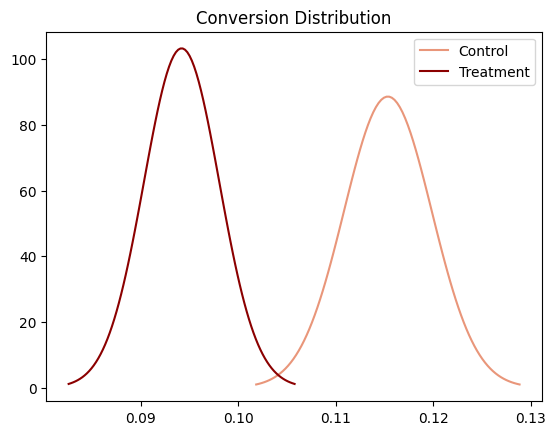

In [ ]:
# create the range of x values
A_line = np.linspace(A_conv - 3 * A_sd,  A_conv + 3 * A_sd, 100)
B_line = np.linspace(B_conv - 3 * B_sd , B_conv + 3 * B_sd, 100)

# plot the normal distribution
plt.plot(A_line, stats.norm.pdf(A_line, A_conv, A_sd), label='Control',color='darksalmon')
plt.plot(B_line, stats.norm.pdf(B_line, B_conv, B_sd), label='Treatment', color='darkred')
plt.title('Conversion Distribution')
plt.legend()

plt.show()

#Analyzing AB Test (RTN)

In [ ]:
#all retention_flg of each group (out of those that converted first)
control_results = df_base[(df_base['test_group'] == 'A') & (df_base['conversion_flg'] == 1)]['retention_flg']
treatment_results = df_base[(df_base['test_group'] == 'B') & (df_base['conversion_flg'] == 1)]['retention_flg']

#number of users
n_con = control_results.count()
n_treat = treatment_results.count()

#number of converted (Control=581)
converted = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat] #list of "number of observations"

z_stat, pval = proportions_ztest(converted, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(converted, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -8.78
p-value: 0.000
ci 95% for control group: [0.135, 0.195]
ci 95% for treatment group: [0.359, 0.442]


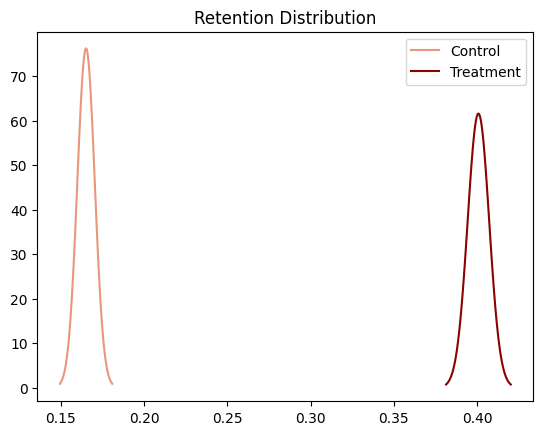

In [ ]:
A_rnt = test_summary.rtn_rate[0]
B_rnt = test_summary.rtn_rate[1]

# calculate the variance
A_var = (A_rnt * (1 - A_rnt)) / A_group
B_var = (B_rnt * (1 - B_rnt)) / B_group

# compute the standard deviations
A_sd = A_var**0.5
B_sd = B_var**0.5

# create the range of x values
A_line = np.linspace(A_rnt - 3 * A_sd,  A_rnt + 3 * A_sd, 100)
B_line = np.linspace(B_rnt - 3 * B_sd , B_rnt + 3 * B_sd, 100)

# plot the normal distribution
plt.plot(A_line, stats.norm.pdf(A_line, A_rnt, A_sd), label='Control',color='darksalmon')
plt.plot(B_line, stats.norm.pdf(B_line, B_rnt, B_sd), label='Treatment', color='darkred')
plt.title('Retention Distribution')
plt.legend()
plt.show()

#LTV Analysis

In [ ]:
#summary
test_summary = df_base.groupby('test_group').agg({'test_group': 'count', 'conversion_flg': 'sum', 'topup_cnt': 'sum',
                                                  'retention_flg': 'sum', 'topup_gmv': 'sum', 'mmm_gmv': 'sum', 'mo_gmv': 'sum'})
test_summary['cvr_rate'] = test_summary.conversion_flg / test_summary.test_group
test_summary['rtn_rate'] = test_summary.retention_flg / test_summary.conversion_flg
test_summary['topup_rate'] = test_summary.topup_cnt / test_summary.conversion_flg

test_summary

,test_group,conversion_flg,topup_cnt,retention_flg,topup_gmv,mmm_gmv,mo_gmv,cvr_rate,rtn_rate,topup_rate
test_group,,,,,,,,,,
A,5036,581,96,96,3771.0,0.00,23196.0,0.115369,0.165232,0.165232
B,5721,539,311,216,11393.9,20049.16,23512.2,0.094214,0.400742,0.576994


[Text(0.5, 0, 'Subscription Type'),
 Text(0, 0.5, 'Avg Monthly GMV'),
 Text(0.5, 1.0, 'Group B Subscription Type v GMV Amount')]

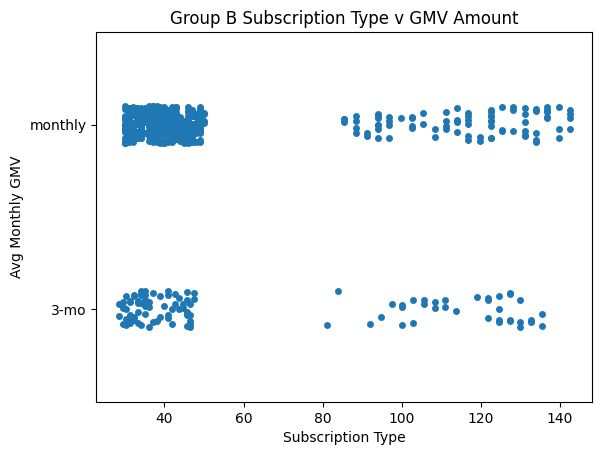

In [ ]:
#plot the behaviour of Group B based on monthly payment amount (converted users)
df_b_base = df_base[(df_base['test_group'] == 'B') & (df_base['conversion_flg'] == 1)]
df_b_base['avg_sub_gmv'] = (df_b_base['mmm_gmv']/3) + df_b_base['mo_gmv']
df_b_base['subx_type'] = df_b_base['mmm_gmv'].apply(lambda x: '3-mo' if x != 0 else 'monthly')

df_b_base[df_b_base['user_id'] == '3519632']

plot = sns.stripplot(x='avg_sub_gmv', y='subx_type', data=df_b_base, jitter=True)
plot.set(xlabel ="Subscription Type", ylabel = "Avg Monthly GMV", title ='Group B Subscription Type v GMV Amount')

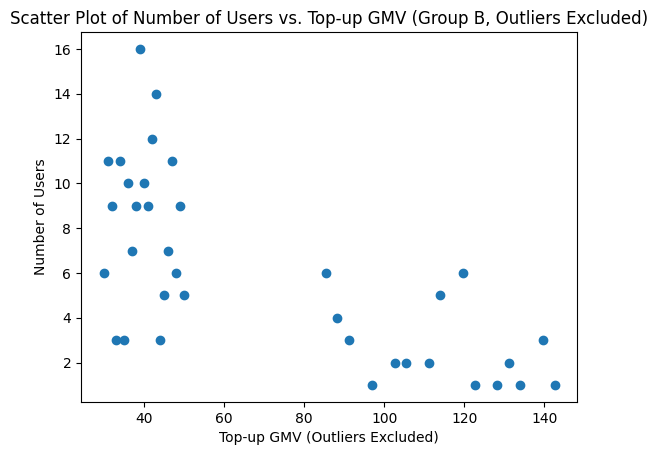

In [ ]:
#plot the behaviour of Group B of those that did NOT convert
df_b_base = df_base[(df_base['test_group'] == 'B') & (df_base['conversion_flg'] == 1) & (df_base['topup_gmv'] > 0)]

df_b_base_user_cnt = df_b_base.groupby('topup_gmv')['user_id'].count().reset_index()
df_b_base_user_cnt.rename(columns={'user_id': 'user_count'}, inplace=True)

plt.scatter(df_b_base_user_cnt['topup_gmv'], df_b_base_user_cnt['user_count'])
plt.xlabel('Top-up GMV (Outliers Excluded)')
plt.ylabel('Number of Users')
plt.title('Scatter Plot of Number of Users vs. Top-up GMV (Group B, Outliers Excluded)')

plt.show()